In [5]:
import json
import os
# Load JSON from file
with open("labels.json", "r") as f:
    data = json.load(f)

In [2]:
len(data)

8578

In [3]:
import pandas as pd

def extract_classification_fields(classification_answers):
    result = {}
    for classification in classification_answers.values():
        try:
            cls = classification['classifications'][0]
            name = cls['name']
            if isinstance(cls.get('answers'), list):
                result[name] = cls['answers'][0]['value']
            else:
                result[name] = cls['answers']
        except (KeyError, IndexError, TypeError):
            continue
    return result

rows = []

for entry in data:
    row = {'video_title': entry.get('data_title')}
    classification_answers = entry.get('classification_answers', {})
    row.update(extract_classification_fields(classification_answers))
    rows.append(row)

df = pd.DataFrame(rows)

In [6]:
df_nvidia = pd.read_csv('nvidia_delivery.csv')
df_nvidia['video_filename_only'] = df_nvidia['video_filename'].apply(os.path.basename)
merged_df = df.merge(df_nvidia, left_on='video_title', right_on='video_filename_only', how='left')
merged_df['event_type'] = merged_df['event_type'].str.lower().str.replace(' ', '_')
merged_df['video_type'] = merged_df['video_type'].str.lower().str.replace(' ', '_')
merged_df[['video_title','event_type','video_type']]
merged_df['event_type'] = merged_df['event_type'].apply(
    lambda x: x if x in ['near_collision', 'collision'] else 'normal'
)

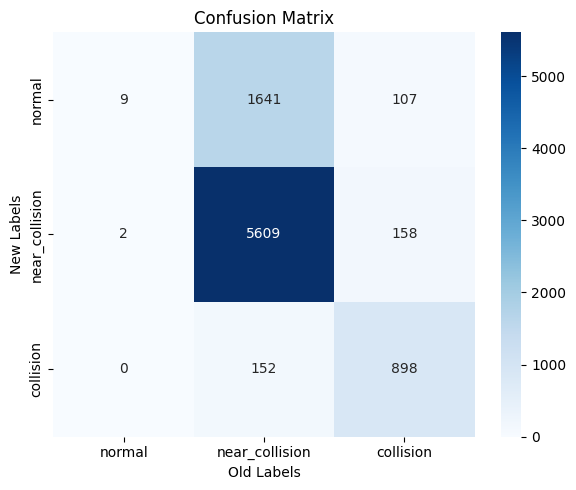

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure clean string values
df_clean = merged_df.dropna(subset=['event_type', 'video_type']).copy()
df_clean['event_type'] = df_clean['event_type'].astype(str)
df_clean['video_type'] = df_clean['video_type'].astype(str)

# Define labels
labels = ["normal", "near_collision", "collision"]

# Compute confusion matrix
cm = confusion_matrix(df_clean['event_type'], df_clean['video_type'], labels=labels)

# Plot with custom axis labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Old Labels')
plt.ylabel('New Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [8]:
df_filtered = df_clean[
    (df_clean['event_type'] == df_clean['video_type']) | 
    ((df_clean['event_type'] == 'normal') & (df_clean['video_type'] == 'near_collision'))
]
df_filtered
df_filtered['event_time (minutes:seconds.milliseconds, e.g. 00:19.44)'].fillna('00:20.00', inplace=True)

/tmp/ipykernel_15669/4120991371.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['event_time (minutes:seconds.milliseconds, e.g. 00:19.44)'].fillna('00:20.00', inplace=True)
/tmp/ipykernel_15669/4120991371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['event_time (minutes:seconds.milliseconds, e.g. 00:19.44)'].

In [9]:
df_filtered['video_path'] = df_filtered['video_filename'] 
df_filtered['video_type'] = df_filtered['event_type']

df_to_train = df_filtered[['id', 'video_title', 'video_path', 'video_type', 'event_time (minutes:seconds.milliseconds, e.g. 00:19.44)']]
import pandas as pd

def parse_event_time(t):
    try:
        minutes, rest = t.split(":")
        seconds = float(rest)
        return int(minutes) * 60 + seconds
    except:
        return None  # או np.nan

df_to_train["event_time_sec"] = df_to_train["event_time (minutes:seconds.milliseconds, e.g. 00:19.44)"].apply(parse_event_time)
df_to_train = df_to_train.loc[df_to_train['event_time_sec']<40].reset_index(drop=True).drop('event_time (minutes:seconds.milliseconds, e.g. 00:19.44)',axis=1)
df_to_train = df_to_train.loc[df_to_train['event_time_sec']>2.5].reset_index(drop=True)

# Filter rows where event_time_sec > 10
df_above_12_5 = df_to_train[df_to_train['event_time_sec'] > 12.5].copy()

# Create duplicated rows with updated event_time_sec and event_type
df_dup = df_above_12_5.copy()
df_dup['event_time_sec'] = df_dup['event_time_sec'] - 12.5
df_dup['video_type'] = 'normal'
df_dup['id'] = df_dup['id'].astype(str) + '_dup'

# Append to original DataFrame
df_augmented = pd.concat([df_to_train, df_dup], ignore_index=True).reset_index(drop=True)

df_augmented['video_type'].value_counts()

/tmp/ipykernel_15669/307525737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['video_path'] = df_filtered['video_filename']
/tmp/ipykernel_15669/307525737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['video_type'] = df_filtered['event_type']
/tmp/ipykernel_15669/307525737.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

video_type
normal            8899
near_collision    5104
collision          827
Name: count, dtype: int64

In [ ]:
df_augmented.to_csv('df_encord_v1.csv',index=False)